In [342]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, StopWordsRemover
spark = SparkSession.builder.appName("Uber Reviews").getOrCreate()


In [343]:
################
##Data Loading##
################
df_original = spark.read.csv("/home/jovyan/Uber_Ride_Reviews.csv", header=True, inferSchema=True)
df_original.show()


+--------------------+-----------+---------+
|         ride_review|ride_rating|sentiment|
+--------------------+-----------+---------+
|I completed runni...|        1.0|        0|
|My appointment ti...|        1.0|        0|
|Whether I using U...|        1.0|        0|
|Why hard understa...|        1.0|        0|
|I South Beach FL ...|        1.0|        0|
|I damage vehicle ...|        1.0|        0|
|I use Uber fairly...|        2.0|        0|
|Last night I retu...|        1.0|        0|
|Do lose anything ...|        1.0|        0|
|My last experienc...|        1.0|        0|
|Our party consist...|        1.0|        0|
|time I extremely ...|        3.0|        1|
|I file class acti...|        1.0|        0|
|If I give stars I...|        1.0|        0|
|I driven KCVG lea...|        1.0|        0|
|I used many times...|        1.0|        0|
|It unfortunate kn...|        2.0|        0|
|DO NOT ACCEPT RID...|        1.0|        0|
|I purchased dolla...|        1.0|        0|
|We used U

In [344]:
#################
##Data cleaning##
#################

#removing netural(3) rating records from the dataset
df_clean = df_original.filter(df_original.ride_rating != 3)

#tokenization
tokenizer = Tokenizer(inputCol="ride_review", outputCol="ride_review_tokens")
df_clean = tokenizer.transform(df_clean)


#remove custom stop words
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'driver', 'uber', 'again', 'there', 
              'about', 'once', 'during', 'very', 'having', 'with', 'they', 'own', 'an', 'be',
              'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'itself', 'other', 
              'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves',
              'until', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 
              'were', 'her', 'more', 'himself', 'this', 'should', 'our', 'their', 'while',
              'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'when', 'at', 'any', 'before',
              'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves',
              'then', 'that', 'because', 'what', 'why', 'so', 'can', 'now', 'he', 'you', 'herself',
              'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'whom',
              'being', 'if', 'theirs', 'my', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here']

stop_words_remover = StopWordsRemover(inputCol='ride_review_tokens', outputCol='ride_review_clean', stopWords=stop_words)
df_clean = stop_words_remover.transform(df_clean)
df_clean.show()
df_clean.summary().show()

+--------------------+-----------+---------+--------------------+--------------------+
|         ride_review|ride_rating|sentiment|  ride_review_tokens|   ride_review_clean|
+--------------------+-----------+---------+--------------------+--------------------+
|I completed runni...|        1.0|        0|[i, completed, ru...|[completed, runni...|
|My appointment ti...|        1.0|        0|[my, appointment,...|[appointment, tim...|
|Whether I using U...|        1.0|        0|[whether, i, usin...|[whether, using, ...|
|Why hard understa...|        1.0|        0|[why, hard, under...|[hard, understand...|
|I South Beach FL ...|        1.0|        0|[i, south, beach,...|[south, beach, fl...|
|I damage vehicle ...|        1.0|        0|[i, damage, vehic...|[damage, vehicle,...|
|I use Uber fairly...|        2.0|        0|[i, use, uber, fa...|[use, fairly, fre...|
|Last night I retu...|        1.0|        0|[last, night, i, ...|[last, night, ret...|
|Do lose anything ...|        1.0|        0

In [345]:
#converting list of strings of a review to list of integers based on frequency of each word in the corpus(total reviews)
cv = CountVectorizer(inputCol="ride_review_clean", outputCol="features")
cv_model = cv.fit(df_clean)
cv_train_df = cv_model.transform(df_clean)
cv_train_df.show()

#split train and test data
train, test = cv_train_df.randomSplit([0.7, 0.3])

+--------------------+-----------+---------+--------------------+--------------------+--------------------+
|         ride_review|ride_rating|sentiment|  ride_review_tokens|   ride_review_clean|            features|
+--------------------+-----------+---------+--------------------+--------------------+--------------------+
|I completed runni...|        1.0|        0|[i, completed, ru...|[completed, runni...|(7559,[0,1,2,3,4,...|
|My appointment ti...|        1.0|        0|[my, appointment,...|[appointment, tim...|(7559,[1,3,5,11,1...|
|Whether I using U...|        1.0|        0|[whether, i, usin...|[whether, using, ...|(7559,[1,3,4,5,6,...|
|Why hard understa...|        1.0|        0|[why, hard, under...|[hard, understand...|(7559,[9,22,32,33...|
|I South Beach FL ...|        1.0|        0|[i, south, beach,...|[south, beach, fl...|(7559,[2,3,6,8,9,...|
|I damage vehicle ...|        1.0|        0|[i, damage, vehic...|[damage, vehicle,...|(7559,[0,22,46,68...|
|I use Uber fairly...|      

In [346]:
#train Logistic Regression model 
lr = LogisticRegression(featuresCol='features', labelCol='sentiment')
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))


Coefficients: [-0.339744105841599,-0.43111053780624387,-0.02519082126073534,0.05863932825663118,0.17896480328436085,-0.05021020841562848,-1.2777837924297033,-1.7974291062447951,-0.6457492767695171,-0.5136863450806359,-1.0866058367917872,-0.03877341372833872,-0.2271579211569782,0.04362423645892005,-0.34679837470768987,0.34014393725824116,0.8942678642643891,-0.35618150509885393,-0.4291179135531752,-0.30899221907530955,-0.4284195210883479,-0.07314176437855609,-0.44432905545108087,-1.3896041303961788,-0.3273603427661488,-0.4817544481439381,-0.19721726912472942,-0.20791395670947938,0.044668796380962834,0.12956920212000403,0.1673330438738231,-0.5041445528119334,-0.2648465567799588,-0.4769811619438329,-0.25165570541919324,-0.5804900738991396,-0.23817181276893232,-0.027557018520475162,-0.44205239401648966,-0.5333000242850354,0.1158033950017903,-0.4631428596972538,-0.7813703759809415,-0.5740882849384774,-0.4733109779936752,0.050927196724714345,1.3495836573920592,-1.258184004933293,0.10899437511

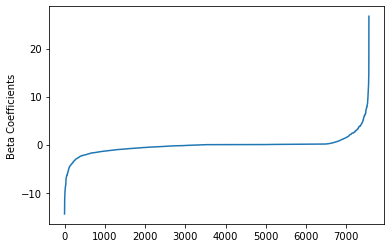

In [347]:
beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [348]:
#prediction
predict_test=lrModel.transform(test)
predict_test.select("ride_review_clean", 'sentiment', 'prediction', 'ride_rating').show()

+--------------------+---------+----------+-----------+
|   ride_review_clean|sentiment|prediction|ride_rating|
+--------------------+---------+----------+-----------+
|[week, ago, boyfr...|        0|       0.0|        1.0|
|[landing, oklahom...|        0|       0.0|        1.0|
|[ran, mailbox, ok...|        0|       0.0|        1.0|
|[assaulted, coupl...|        0|       0.0|        1.0|
|[asked, suppose, ...|        0|       0.0|        1.0|
|[first, issue, ch...|        1|       0.0|        5.0|
|[alert, selecting...|        0|       0.0|        1.0|
|[charged, extra, ...|        0|       1.0|        1.0|
|[trying, start, w...|        0|       0.0|        1.0|
|[booked, ride, ta...|        0|       0.0|        1.0|
|[called, black, c...|        0|       0.0|        1.0|
|[cell, left, vehi...|        0|       0.0|        1.0|
|[charged, get, dr...|        0|       0.0|        1.0|
|[cut, fees, want,...|        0|       0.0|        1.0|
|[not, buy, gift, ...|        0|       0.0|     

In [349]:
#Words and their respective coef
df = pd.DataFrame({'Word':cv_model.vocabulary, 'Coef': lrModel.coefficients})
df.sort_values('Coef').head(20)

,Word,Coef
1386,children,-14.413943
2327,ur,-12.678240
6850,preposterous,-12.525530
537,nyc,-12.162441
3419,split,-11.207786
1943,ing,-11.159885
3455,stranding,-10.852554
4226,groupon,-10.654752
541,zero,-10.134615
3280,yelp,-9.973842


In [350]:
#Inspect tool
predict_test.filter(predict_test['prediction'] == 1) \
    .select("sentiment","ride_rating","probability","prediction", "ride_review") \
    .orderBy("probability", ascending=False) \
    .show(n = 50, truncate = 50)

+---------+-----------+-------------------------------------------+----------+--------------------------------------------------+
|sentiment|ride_rating|                                probability|prediction|                                       ride_review|
+---------+-----------+-------------------------------------------+----------+--------------------------------------------------+
|        0|        1.0|   [0.46495887746364983,0.5350411225363502]|       1.0|I sick Uber drivers rude disgusting attitude We...|
|        0|        1.0|   [0.42762966354940873,0.5723703364505912]|       1.0|Our son accidentally left bag backseat Uber rid...|
|        1|        5.0|   [0.30455804738675135,0.6954419526132487]|       1.0|I use UBER I go Pittsburgh daughter wants go sh...|
|        1|        5.0|    [0.2806226935672581,0.7193773064327419]|       1.0|Uber like dream come true yes nice comfortable ...|
|        0|        1.0|   [0.27457902512252425,0.7254209748774757]|       1.0|Used Uber fi

+---------+----------+-------------------------------------------+
|sentiment|prediction|probability                                |
+---------+----------+-------------------------------------------+
|0        |0.0       |[1.0,3.0760201622207513E-21]               |
|0        |0.0       |[0.9998783531067645,1.2164689323555683E-4] |
|0        |0.0       |[0.9996110100009976,3.889899990023713E-4]  |
|0        |0.0       |[0.9999716965881145,2.8303411885604996E-5] |
|0        |0.0       |[1.0,2.3029377708541827E-23]               |
|1        |0.0       |[0.9988672094439901,0.0011327905560099328] |
|0        |0.0       |[0.999995527906186,4.472093814054147E-6]   |
|0        |1.0       |[8.603818944489698E-4,0.999139618105551]   |
|0        |0.0       |[0.9999999995916959,4.0830399104700496E-10]|
|0        |0.0       |[0.9999996241261354,3.758738645526198E-7]  |
|0        |0.0       |[0.9999999999998883,1.1176230071178501E-13]|
|0        |0.0       |[0.9999998551602644,1.4483973567344224E-

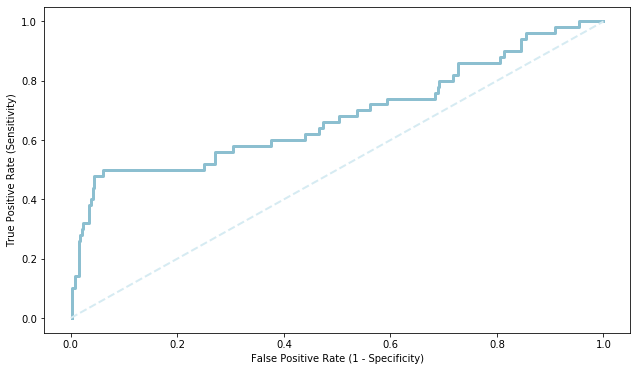

In [357]:
labels_and_scores = predict_test.select('sentiment', 'prediction')
labels_and_weights = labels_and_scores.collect()
labels_and_weights.sort(key=lambda x: x[1], reverse=True)
labels_by_weight = np.array([k for (k, v) in labels_and_weights])

length = labels_by_weight.size
true_positives = labels_by_weight.cumsum()
num_positive = true_positives[-1]
false_positives = np.arange(1.0, length + 1, 1.) - true_positives

true_positive_rate = true_positives / num_positive
false_positive_rate = false_positives / (length - num_positive)

# Generate layout and plot data
fig, ax = plt.subplots(figsize=(10.5, 6), facecolor='white', edgecolor='white')
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(false_positive_rate, true_positive_rate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model



#Evaluate model

#evaluation of the model
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="sentiment")
predict_test.select("sentiment","prediction","probability").show(truncate=False)


In [356]:
def evaluate(predictionAndLabels):
    log = {}

    print("Training:\n Area Under ROC: " + str(trainingSummary.areaUnderROC))
    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)    
    print("Testing:\nArea under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (float(line[1]), float(line[0])))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    log['precision'] = "%s" % metrics.precision()
    log['recall'] = "%s" % metrics.recall()
    log['F1 Measure'] = "%s" % metrics.fMeasure()
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % \
            (log['precision'], log['recall'], log['F1 Measure']))

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label, 
                                                           beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s" \
                  % (label, log[label]['precision'], 
                    log[label]['recall'], log[label]['F1 Measure']))

    return log
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
evaluate(predict_test.withColumnRenamed('sentiment', 'label'))

Training:
 Area Under ROC: 0.9999118070730728
Testing:
Area under ROC = 0.852326
Area under PR = 0.573020
[[328.  16.]
 [ 26.  24.]]
[Overall]	precision = 0.8934010152284264 | recall = 0.8934010152284264 | F1 Measure = 0.8934010152284264
[Class 0.0]	precision = 0.9265536723163842 | recall = 0.9534883720930233 | F1 Measure = 0.9398280802292264
[Class 1.0]	precision = 0.6 | recall = 0.48 | F1 Measure = 0.5333333333333332


{'AUROC': '0.852326',
 'AUPR': '0.573020',
 'precision': '0.8934010152284264',
 'recall': '0.8934010152284264',
 'F1 Measure': '0.8934010152284264',
 0.0: {'precision': '0.9265536723163842',
  'recall': '0.9534883720930233',
  'F1 Measure': '0.9398280802292264'},
 1.0: {'precision': '0.6',
  'recall': '0.48',
  'F1 Measure': '0.5333333333333332'}}